In [47]:
from os import replace
import numpy as np
import pandas as pd
from pandas.tseries.offsets import YearOffset
from seaborn.miscplot import palplot
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
import statsmodels.api as sm
from statsmodels.graphics.api import abline_plot
from sklearn.tree import DecisionTreeClassifier

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
plt.switch_backend('agg')
matplotlib.rcParams['figure.dpi'] = 300
plt.style.use('seaborn-deep')
sns.set()
from matplotlib import rcParams

# locals
import utils
import ml_eval

%matplotlib inline


In [2]:
LABEL_PATH = f"../prepared_data/google_labels.csv"
label_df = pd.read_csv(LABEL_PATH)
print(f"raw labels: {label_df.shape}")

score_cols = [x for x in label_df.columns if '_score' in x]
ids_cols = [
    'census_tract',
    'city',
    'county',
    'image_id',
    'tile_id',
    'tile_latitude',
    'tile_longitude'
]

label_df = label_df[score_cols + ids_cols]
print(f"subset labels: {label_df.shape}\n")

raw labels: (1172, 331)
subset labels: (1172, 169)



In [3]:
CITIES_PATH = "../prepared_data/500_cities.csv"
city_df = pd.read_csv(CITIES_PATH)

city_df.head()

print(f"raw city: {city_df.shape}")

cols_of_interest = [
 'BPHIGH_CrudePrev',
 'BPMED_CrudePrev',
 'CHD_CrudePrev',
 'CHOLSCREEN_CrudePrev',
 'DIABETES_CrudePrev',
 'OBESITY_CrudePrev',
 'PHLTH_CrudePrev',
 'Population2010',
 'STROKE_CrudePrev',
]

city_df = city_df[cols_of_interest + ['tile_id']]
print(f"subset labels: {city_df.shape}\n")

raw city: (1172, 71)
subset labels: (1172, 10)



In [4]:
df = pd.merge(label_df, 
              city_df, 
              how='left',
               on='tile_id')
print(df.shape)

# add binary dummy coding for ann arbor and dt
df['CITY_BINARY'] = np.where(df['city'] == 'Ann Arbor', 1, -1)

df.head()

(1172, 178)


Bird's-eye_view_score  Brown_score  Aerial_photography_score  Road_score  \
0                    0.0     0.000000                  0.000000         0.0   
1                    0.0     0.000000                  0.794495         0.0   
2                    0.0     0.000000                  0.000000         0.0   
3                    0.0     0.000000                  0.513767         0.0   
4                    0.0     0.812311                  0.000000         0.0   

   Grass_score  Birch_score  Metal_score  Neighbourhood_score  \
0          0.0          0.0     0.000000                  0.0   
1          0.0          0.0     0.000000                  0.0   
2          0.0          0.0     0.511452                  0.0   
3          0.0          0.0     0.607061                  0.0   
4          0.0          0.0     0.000000                  0.0   

   Real_estate_score  Marble_score     ...       BPHIGH_CrudePrev  \
0                0.0           0.0     ...                   30.0   
1                0.0           0.0     ...                   30.0   
2                0.0           0.0     ...                   30.0   
3                0.0           0.0     ...                   27.5   
4                0.0           0.0     ...                   27.5   

   BPMED_CrudePrev  CHD_CrudePrev  CHOLSCREEN_CrudePrev  DIABETES_CrudePrev  \
0             77.1            5.3                  86.1                 7.6   
1             77.1            5.3                  86.1                 7.6   
2             77.1            5.3                  86.1                 7.6   
3             72.6            4.8                  75.1                 8.5   
4             72.6            4.8                  75.1                 8.5   

   OBESITY_CrudePrev  PHLTH_CrudePrev  Population2010  STROKE_CrudePrev  \
0               23.7              6.9          1106.0               2.0   
1               23.7              6.9          1106.0               2.0   
2               23.7              6.9          1106.0               2.0   
3               28.8              9.2          2902.0               2.3   
4               28.8              9.2          2902.0               2.3   

   CITY_BINARY  
0            1  
1            1  
2            1  
3            1  
4            1  

[5 rows x 179 columns]

In [5]:
print(df['census_tract'].nunique())

aa = df[df['city'] == 'Ann Arbor']
dt = df[df['city'] == 'Detroit']

print(aa['census_tract'].nunique())
print(dt['census_tract'].nunique())

324
33
291


Working: High BP
Working: High BP Medicated
Working: Coronary Heart Disease
Working: High Cholesterol
Working: Diabetes
Working: Obesity
Working: Physical Health
Working: Stroke


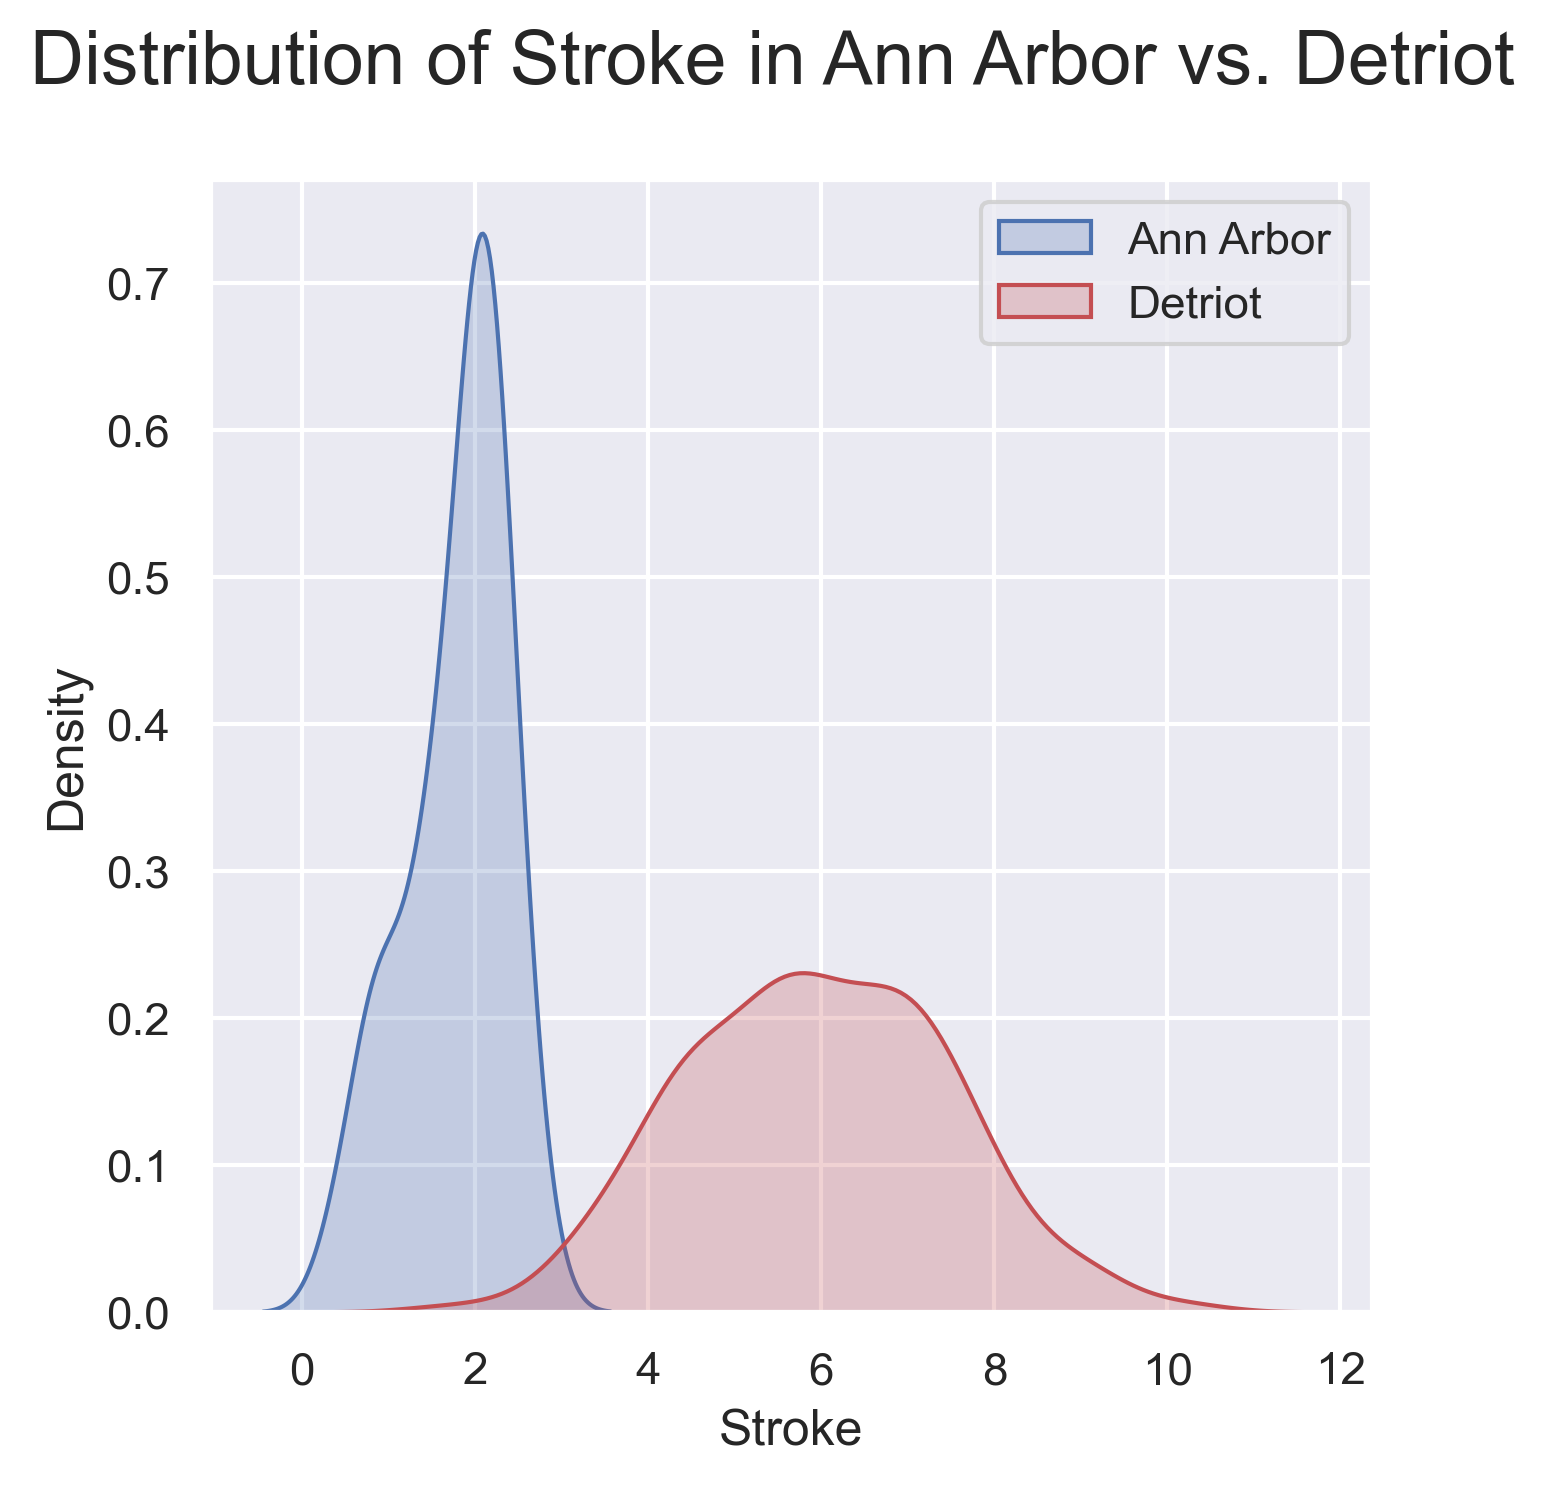

In [6]:

matplotlib.rcParams['figure.dpi'] = 200
matplotlib.rcParams['figure.figsize'] = 5, 5

ANALYSIS_COLUMNS = {
 'BPHIGH_CrudePrev' : 'High BP',
 'BPMED_CrudePrev' : 'High BP Medicated',
 'CHD_CrudePrev' : 'Coronary Heart Disease',
 'CHOLSCREEN_CrudePrev' : 'High Cholesterol',
 'DIABETES_CrudePrev' : 'Diabetes',
 'OBESITY_CrudePrev' : 'Obesity',
 'PHLTH_CrudePrev' : 'Physical Health',
 'STROKE_CrudePrev' : 'Stroke',
}

for COLUMN, label in ANALYSIS_COLUMNS.items():
    plt.cla()
    OUTPUT_DIR = f"../figures/"
    print(f'Working: {label}')

    aa = df[df['city'] == 'Ann Arbor']

    # remove to reduce skew
    aa = aa.drop_duplicates(subset='census_tract')

    dt = df[df['city'] == 'Detroit']
    
    # remove to reduce skew
    dt = dt.drop_duplicates(subset='census_tract')

    TITLE = f'Distribution of {label} in Ann Arbor vs. Detriot'

    sns.kdeplot(aa[COLUMN], 
                shade=True, 
                color="C0",
                label='Ann Arbor')

    sns.kdeplot(dt[COLUMN], 
                shade=True, 
                color="C3",
                label='Detriot')

    plt.suptitle(TITLE,  fontsize=18)
    plt.legend()
    plt.xlabel(label)
    save_filepath = f"{OUTPUT_DIR}{TITLE}.png"
    plt.savefig(save_filepath,  bbox_inches = 'tight')


In [7]:

EXCLUSIONS = []

for col in score_cols:
    t = df.groupby(['city'], as_index=False)[col].max()
    if t[col].min() == 0:
        EXCLUSIONS.append(col)

INCLUSIONS = [x for x in score_cols if not x in EXCLUSIONS]
print(len(score_cols))
print(len(INCLUSIONS))

162
44


In [8]:

N_COMPONENTS = 12 # note that 12 is where the explained variance ratio reaches ~.80
# N_COMPONENTS = 11 # 11 for exclusions
pca = PCA(n_components=N_COMPONENTS, svd_solver='full')

X = pca.fit_transform(df[INCLUSIONS])
# X_excl = pca.fit_transform(df[EXCLUSIONS])
print(np.cumsum(pca.explained_variance_ratio_))

pca_columns = []

for i in range(N_COMPONENTS):
    new_label = f"PCA_{i+1}"
    pca_columns.append(new_label)
    df[new_label] = X[:, i]

    # df[new_label] = X_excl[:, i]

[0.24330963 0.38869847 0.49321901 0.55636019 0.61150507 0.65900733
 0.69352646 0.72202018 0.74735163 0.77033153 0.79197327 0.8110321 ]


rastructure_score        -0.0221      0.300     -0.074      0.941      -0.610       0.566
Land_lot_score               0.0447      0.283      0.158      0.874      -0.510       0.599
Facade_score                -0.0386      0.430     -0.090      0.928      -0.881       0.803
City_score                  -0.0566      0.294     -0.193      0.847      -0.633       0.519
Photograph_score            -0.0566      0.451     -0.126      0.900      -0.940       0.827
Transport_score              0.1896      1.353      0.140      0.889      -2.463       2.842
Photography_score           -0.0078      0.412     -0.019      0.985      -0.815       0.799
Metropolitan_area_score     -0.0396      0.283     -0.140      0.889      -0.595       0.515
Camouflage_score             0.1609      2.182      0.074      0.941      -4.115       4.437
Suburb_score                 0.0385      0.282      0.137      0.891      -0.515       0.592
Urban_area_score             0.0310      0.353      0.088      0.930     

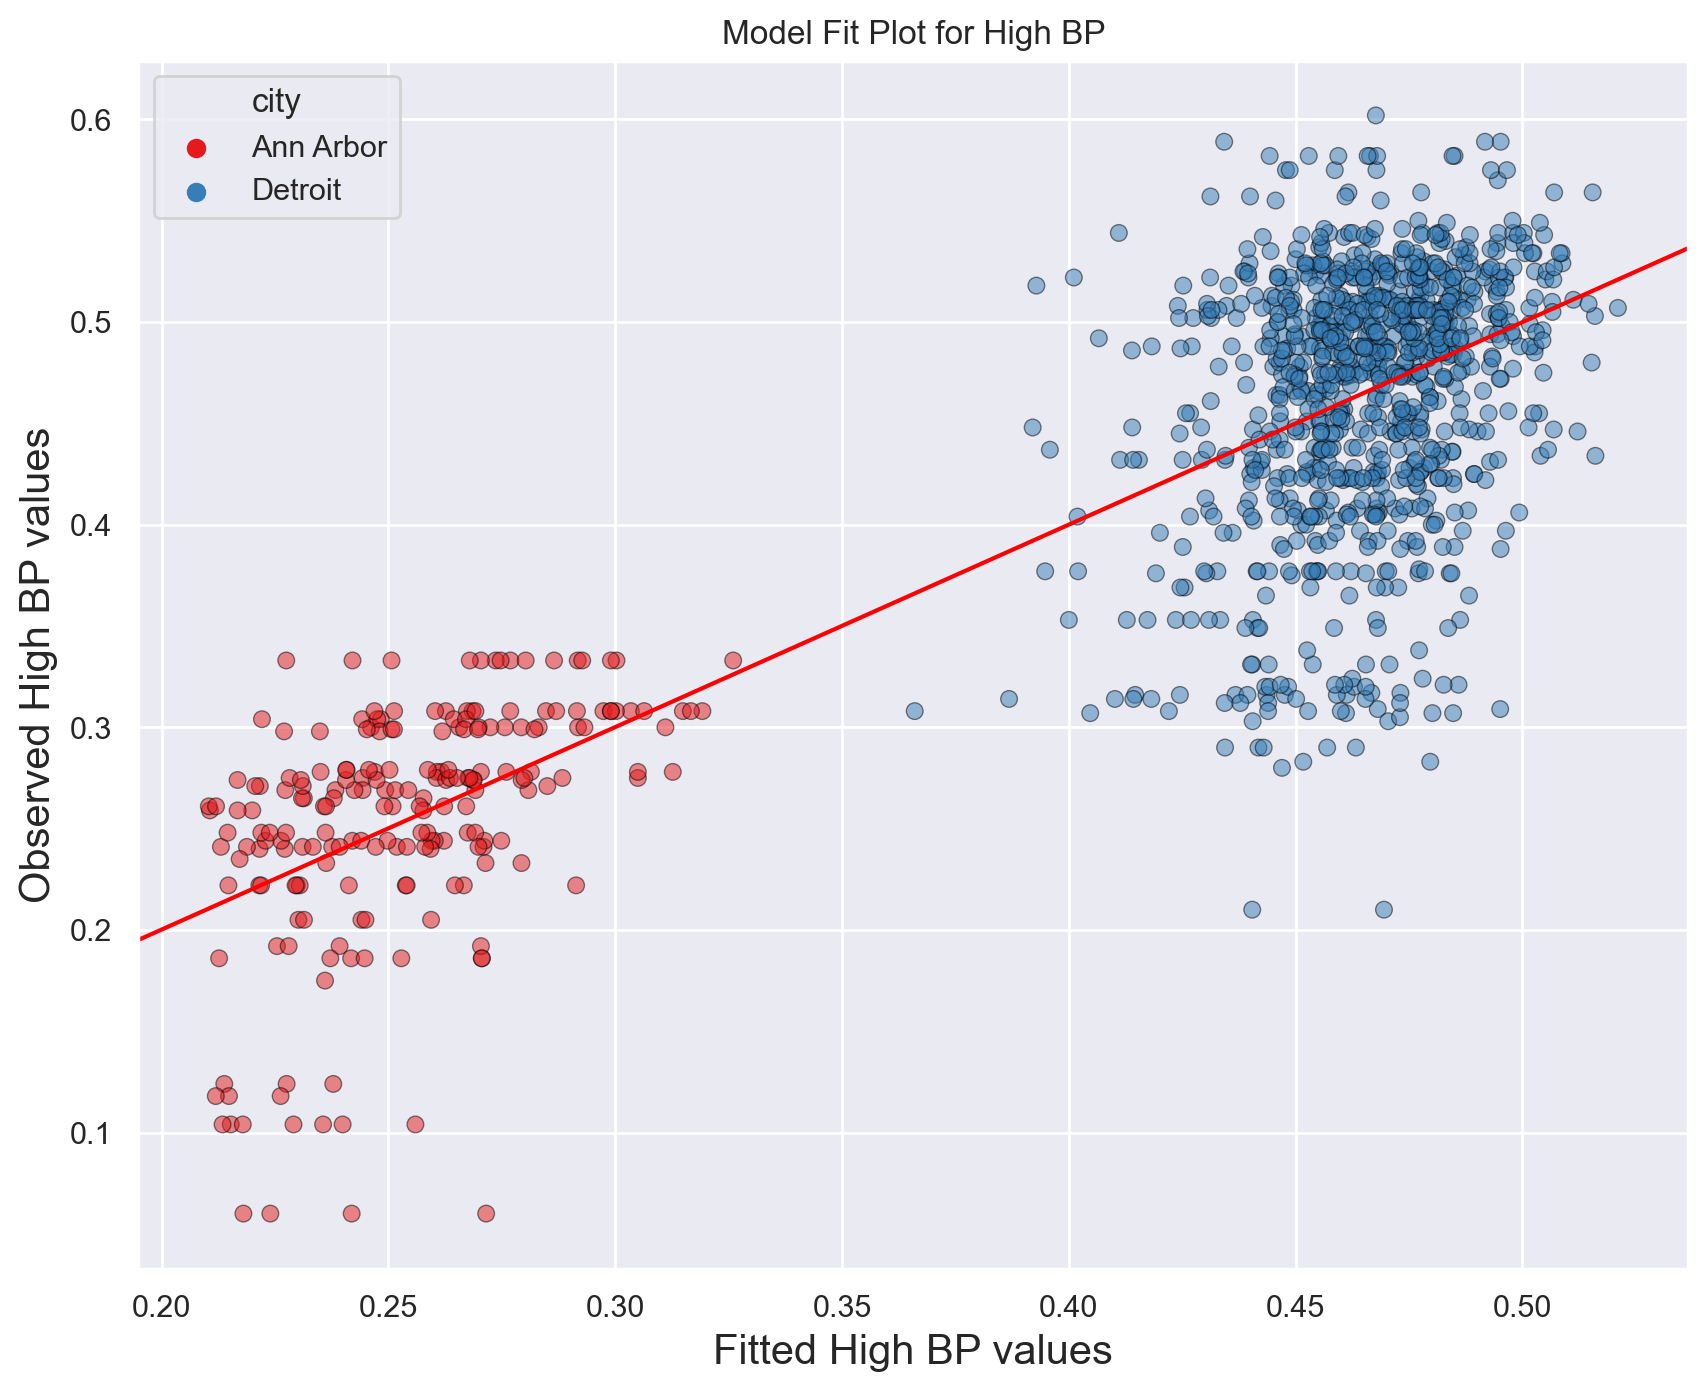

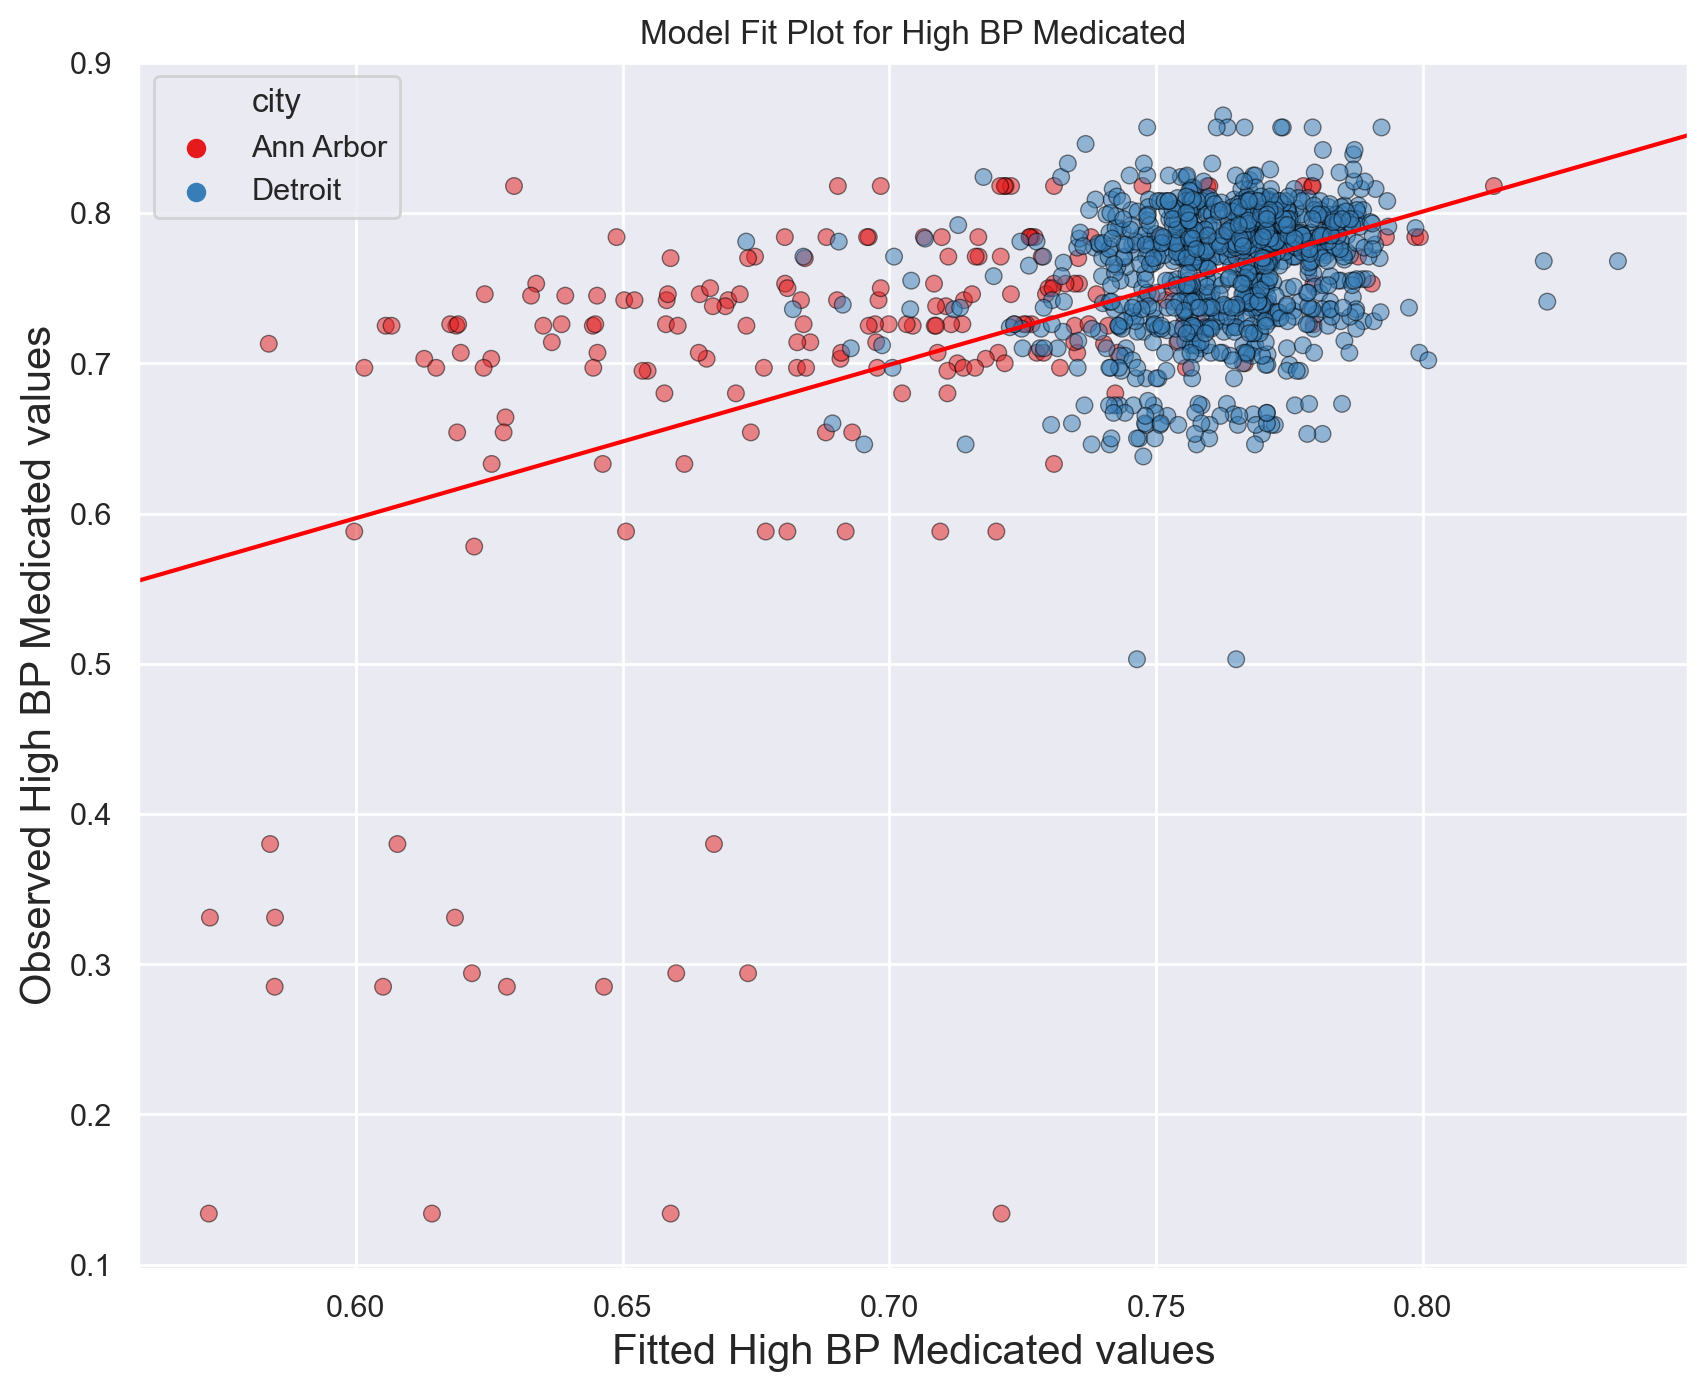

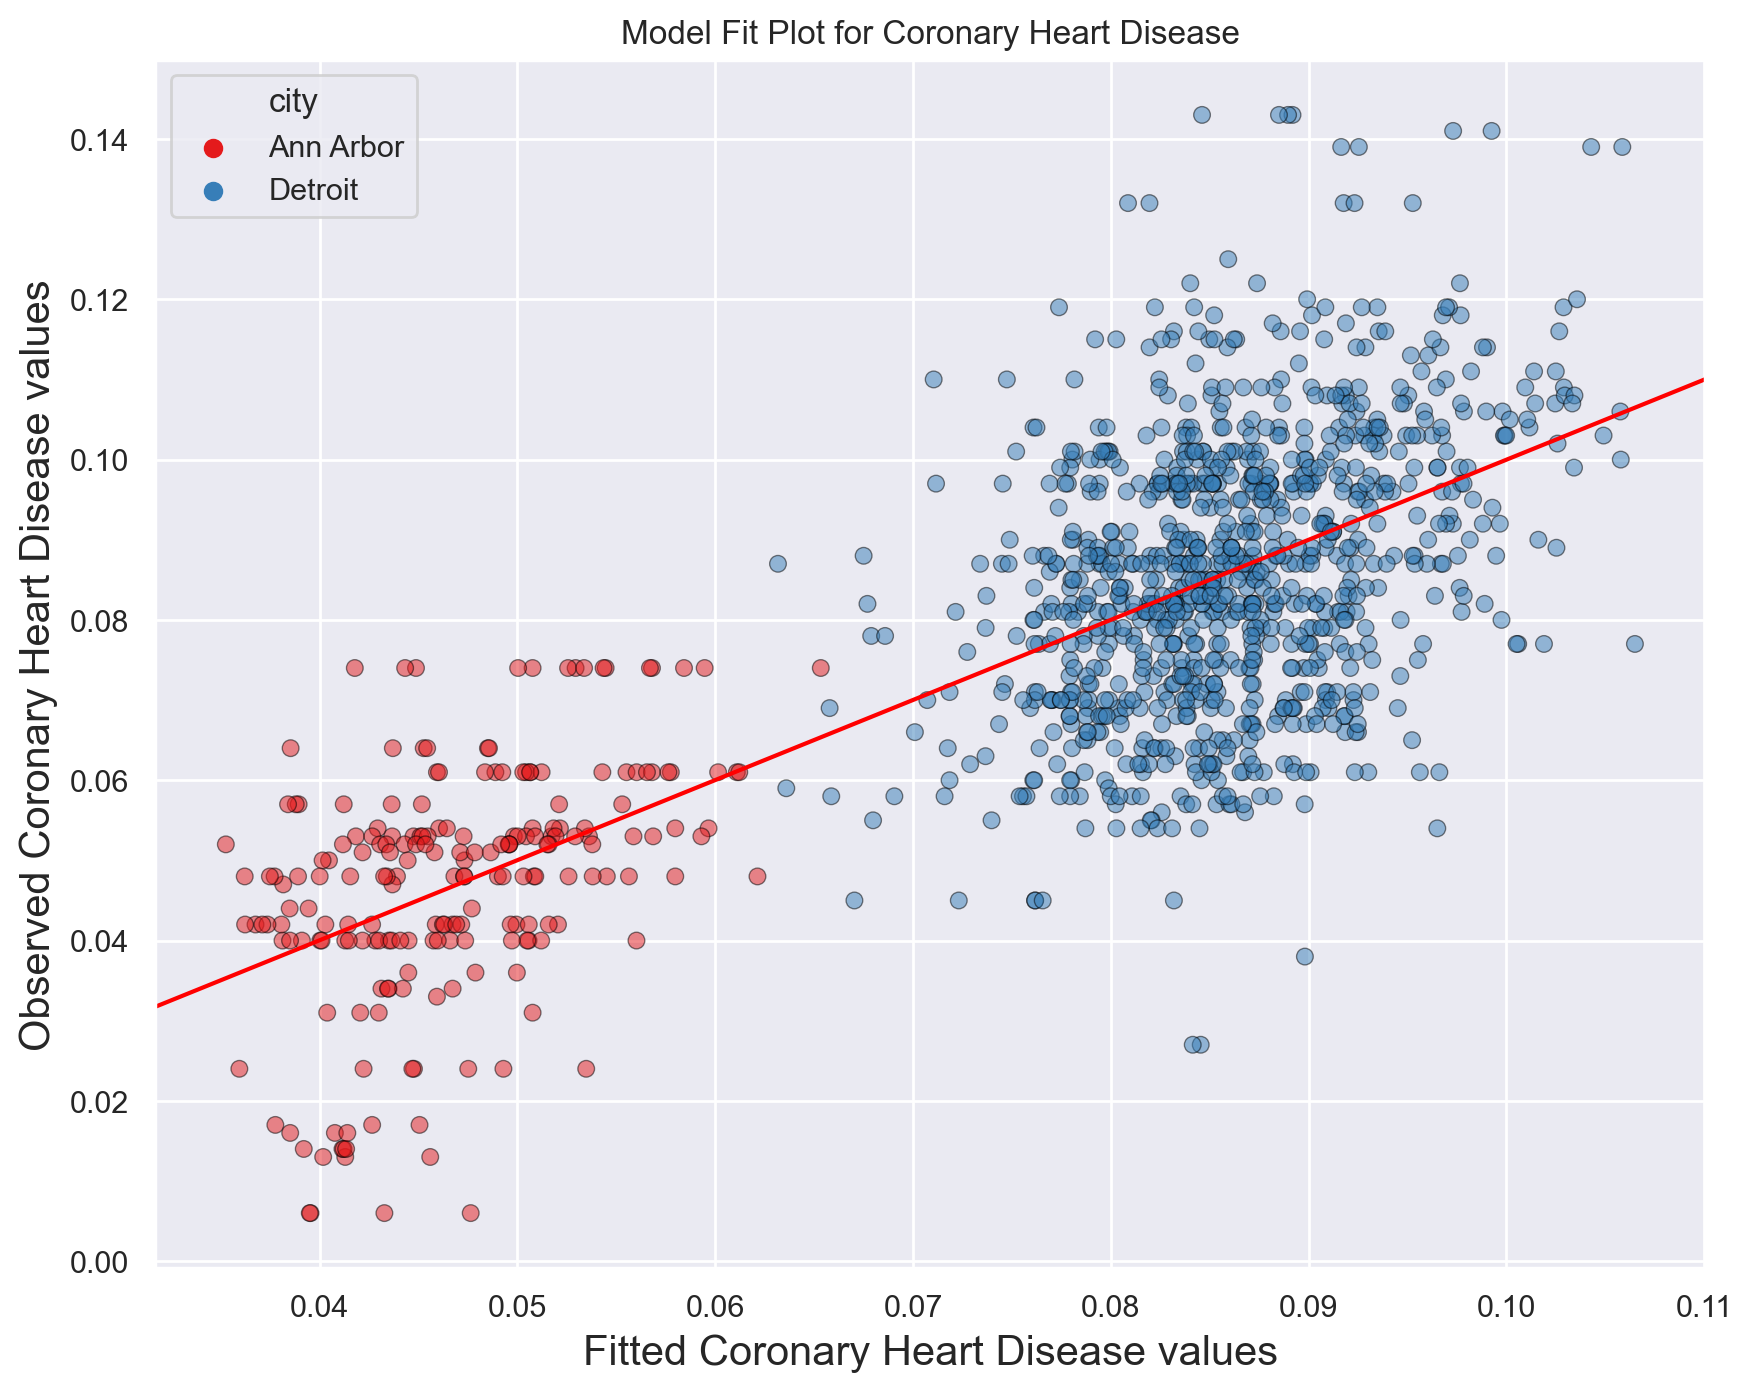

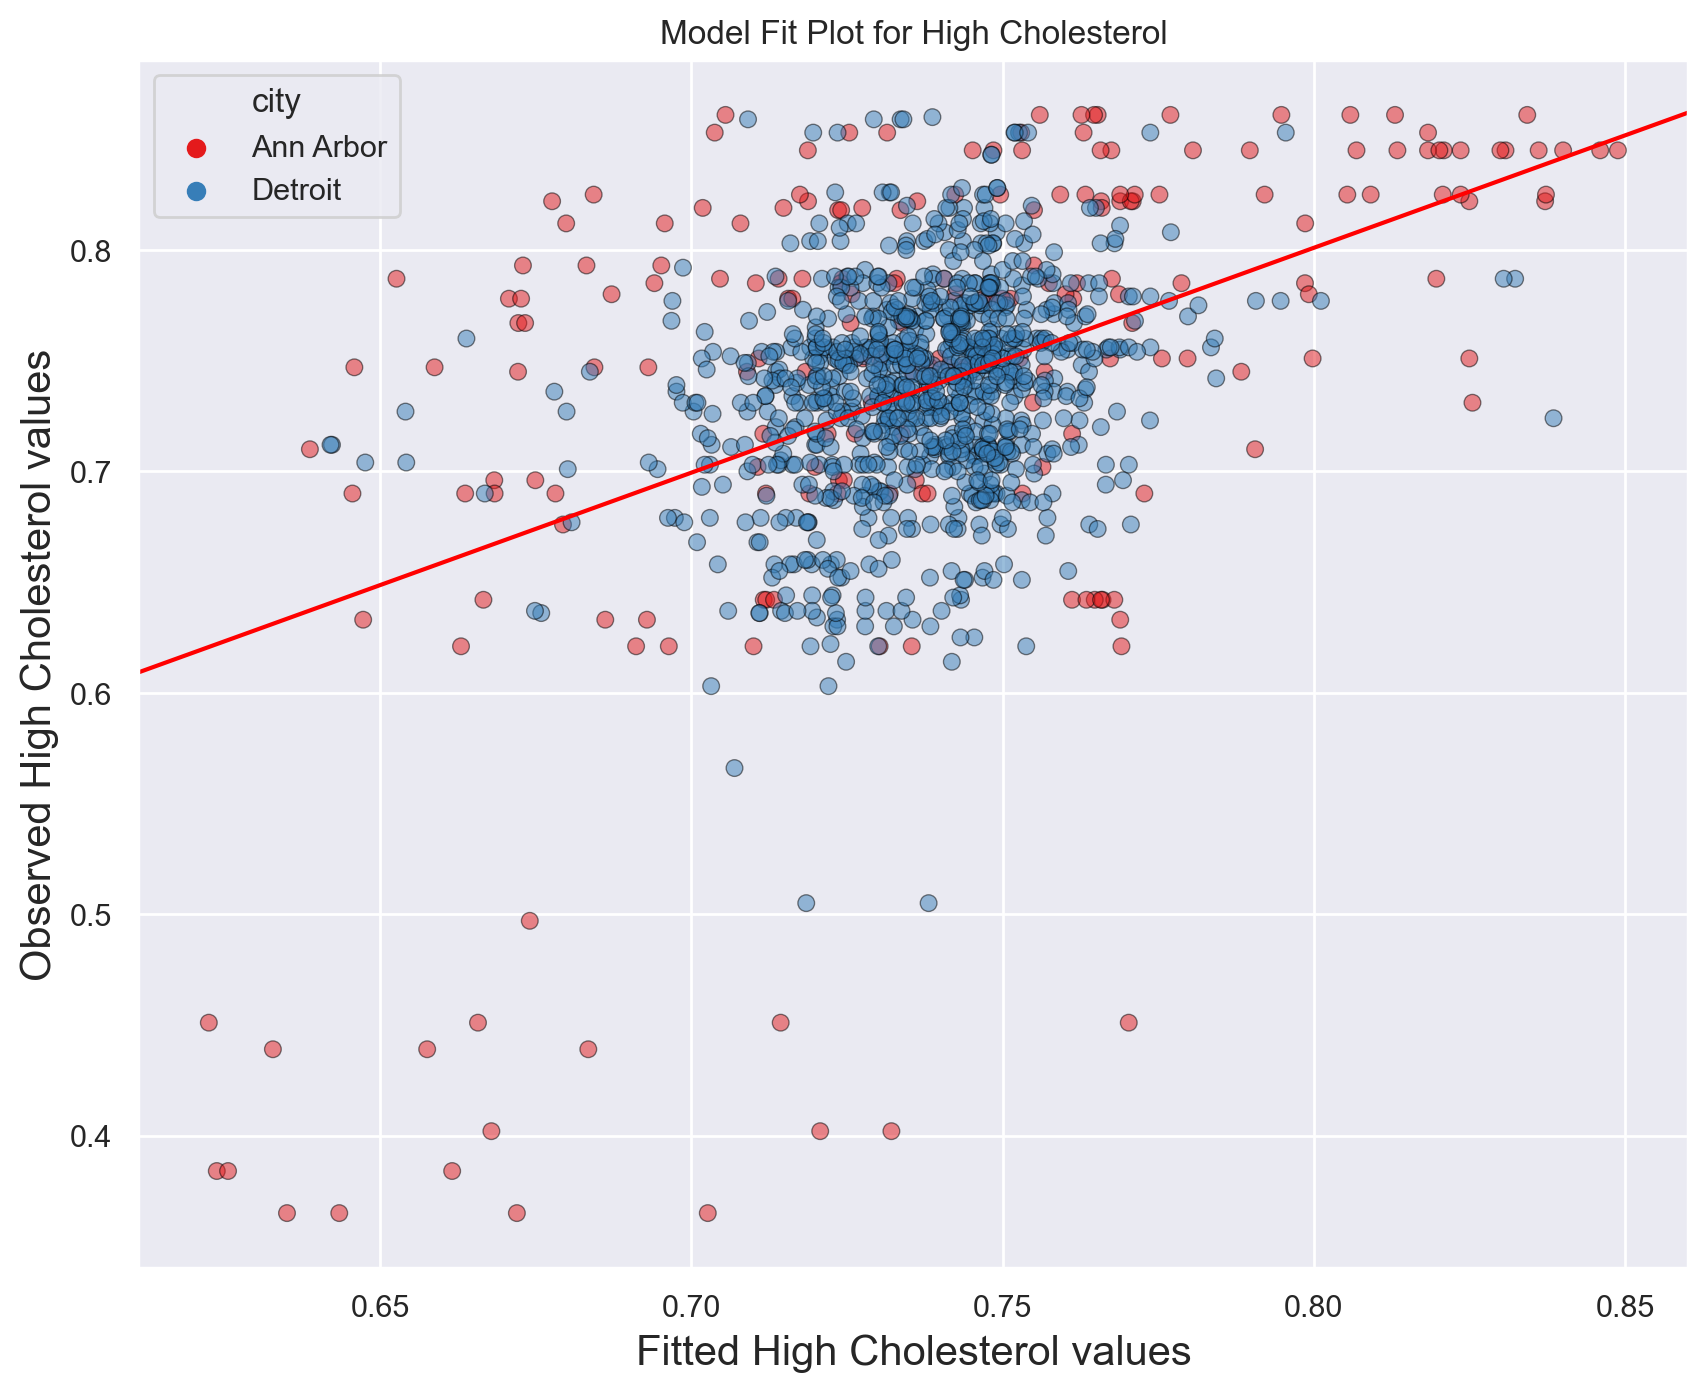

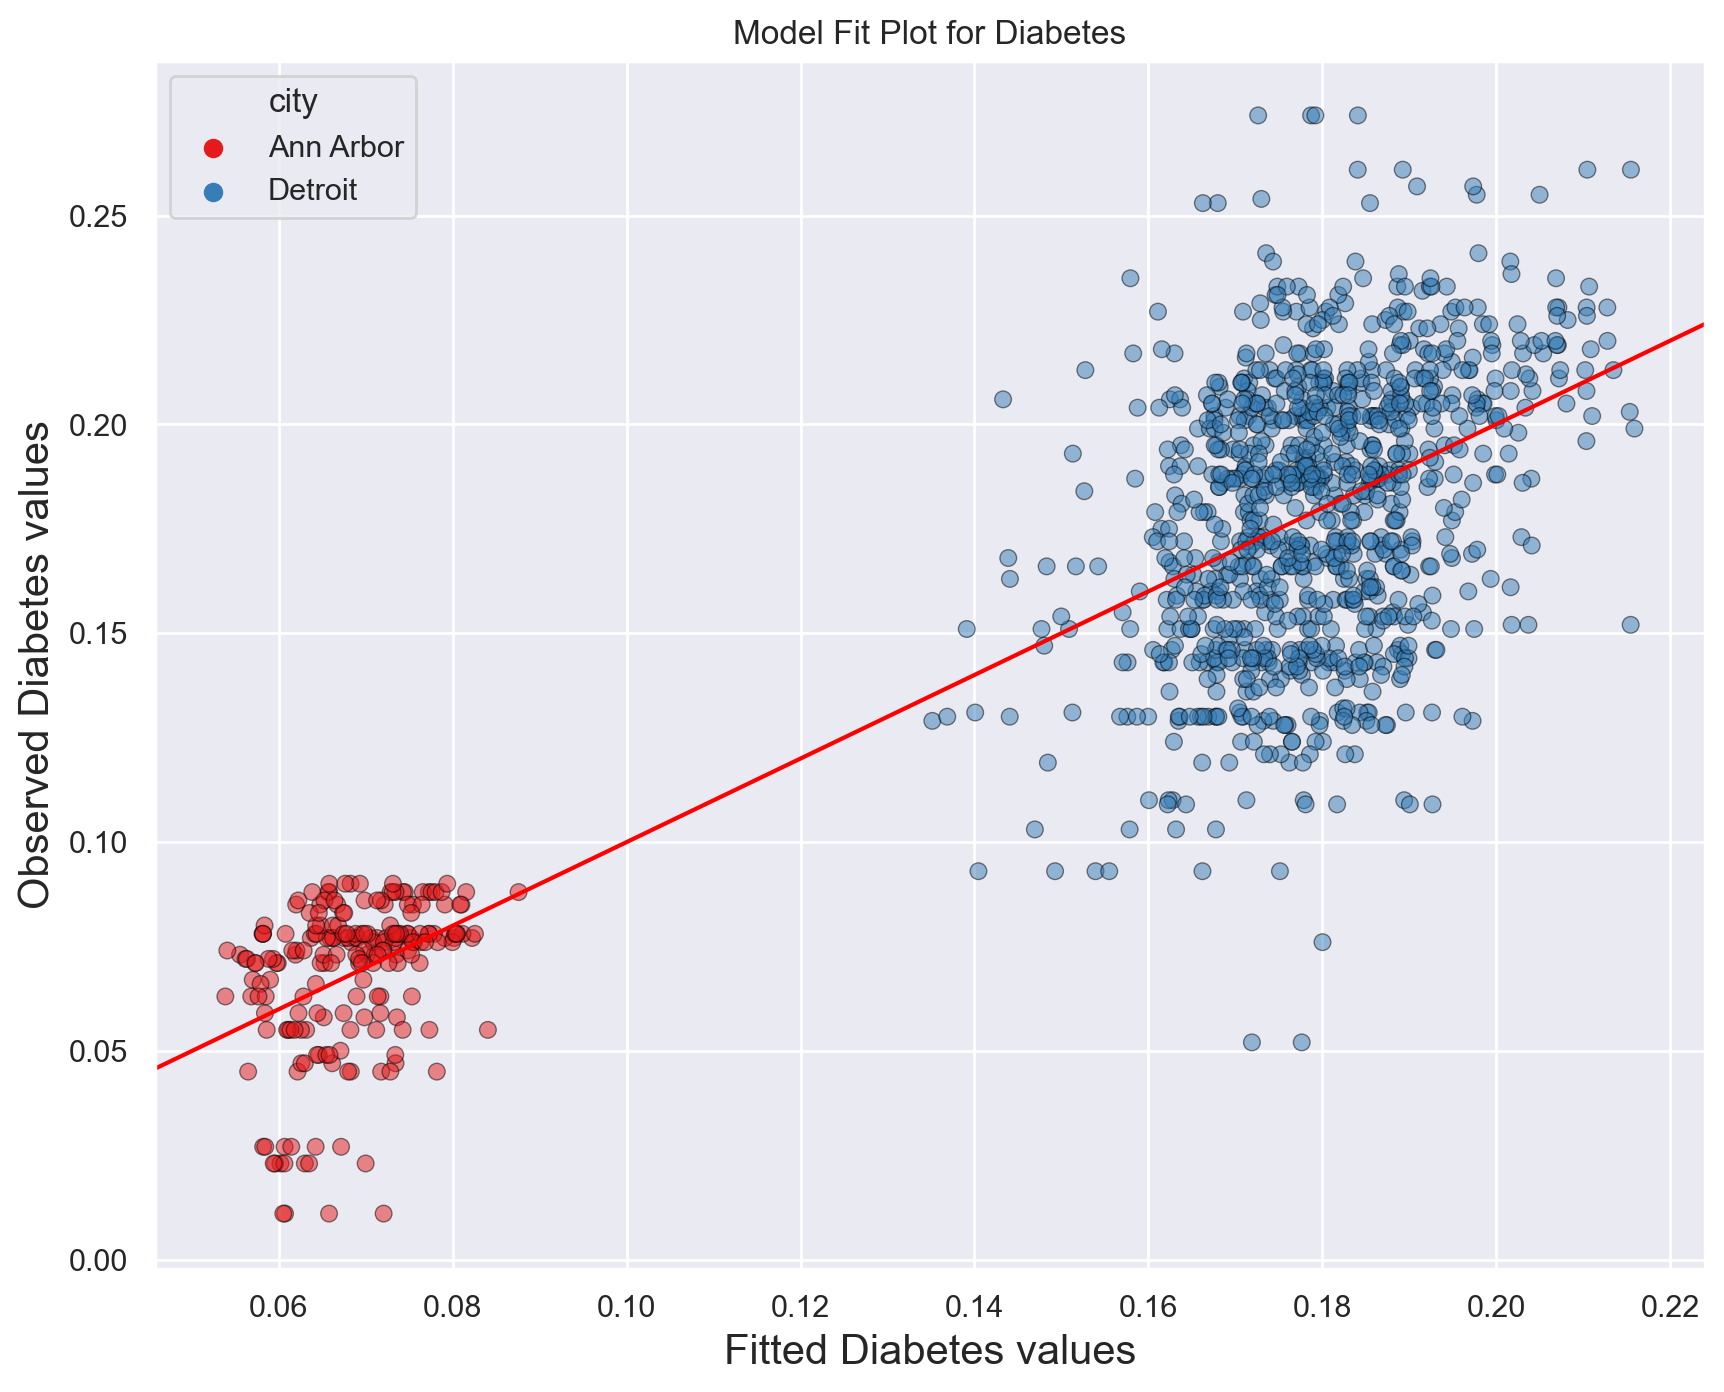

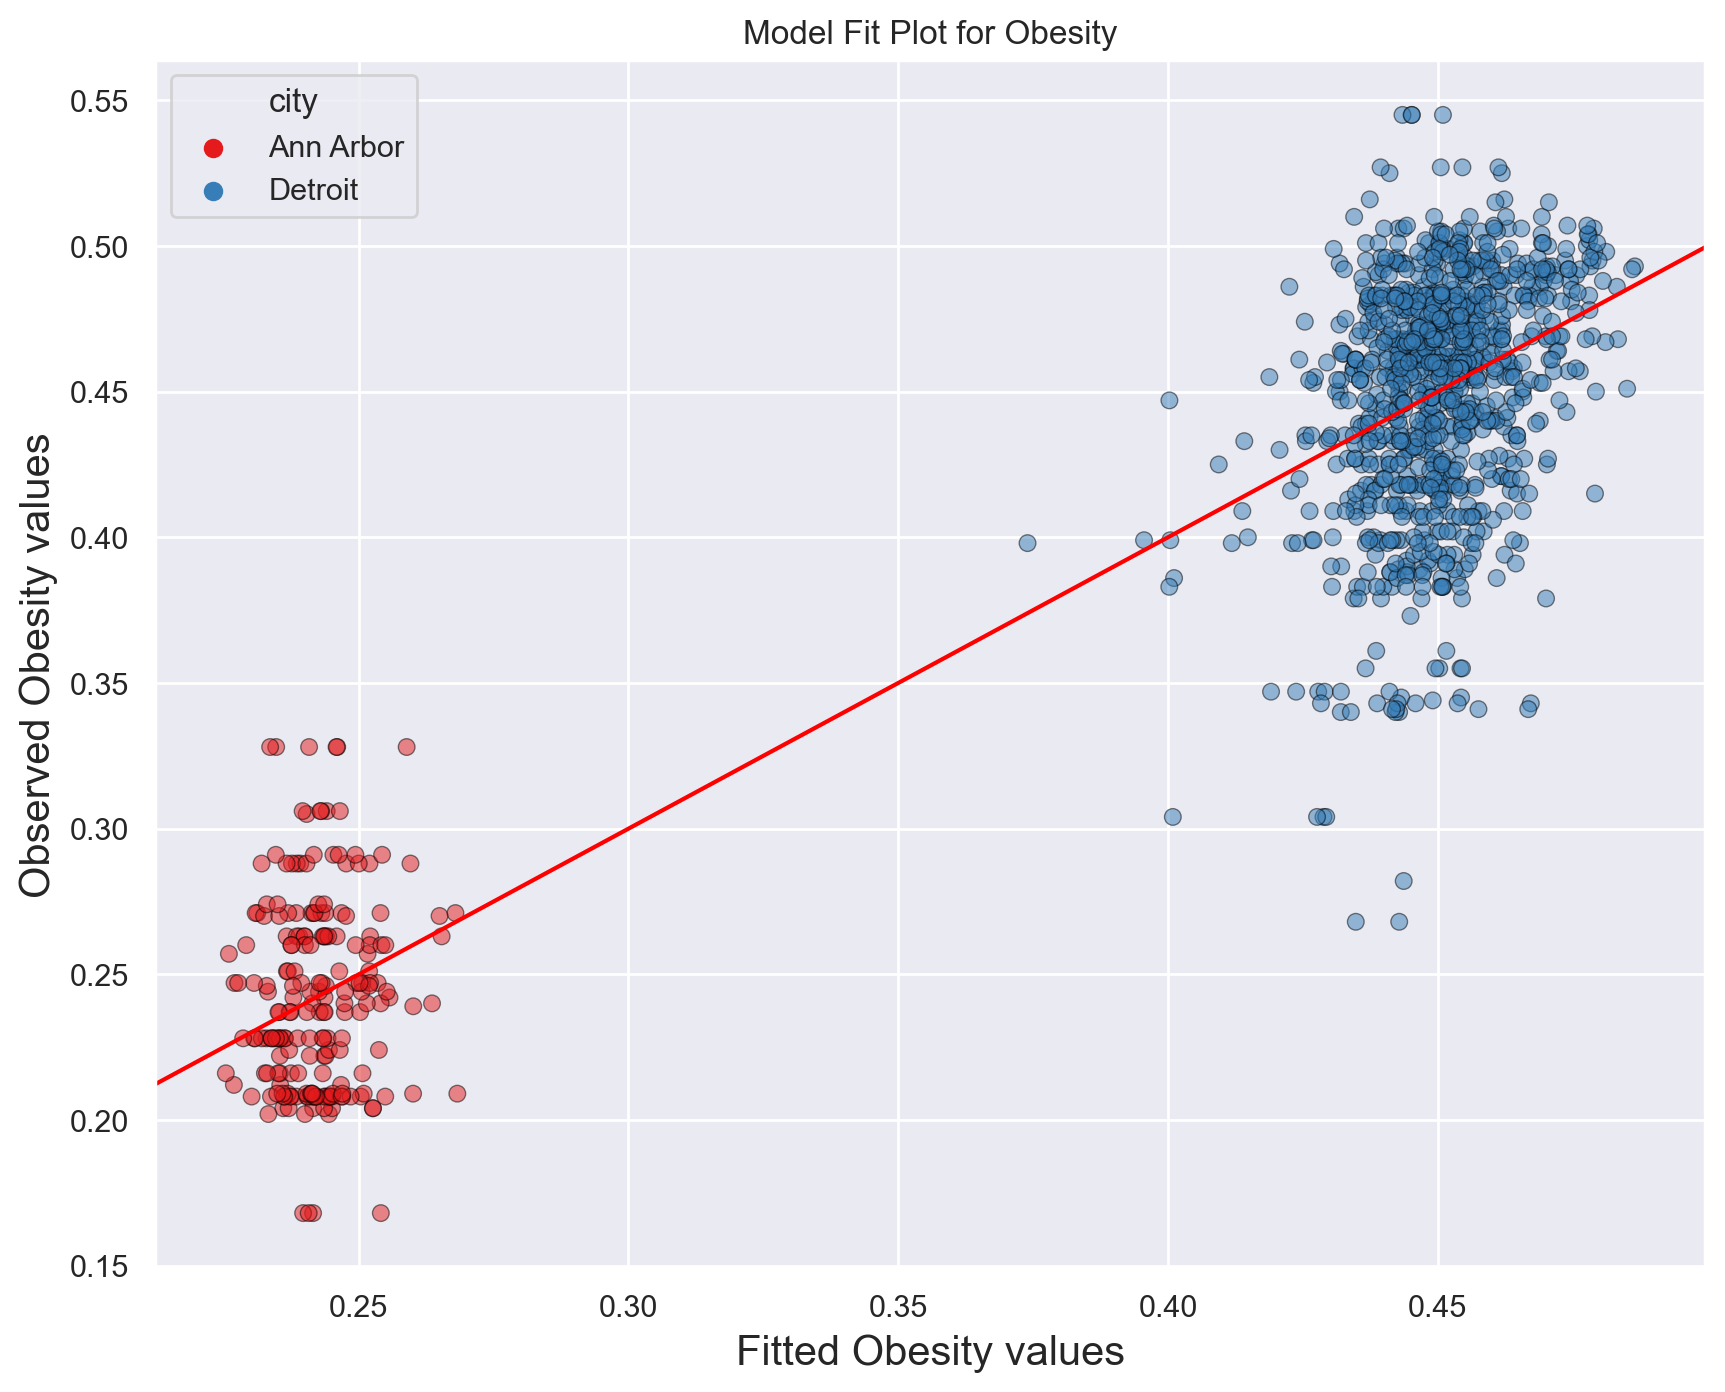

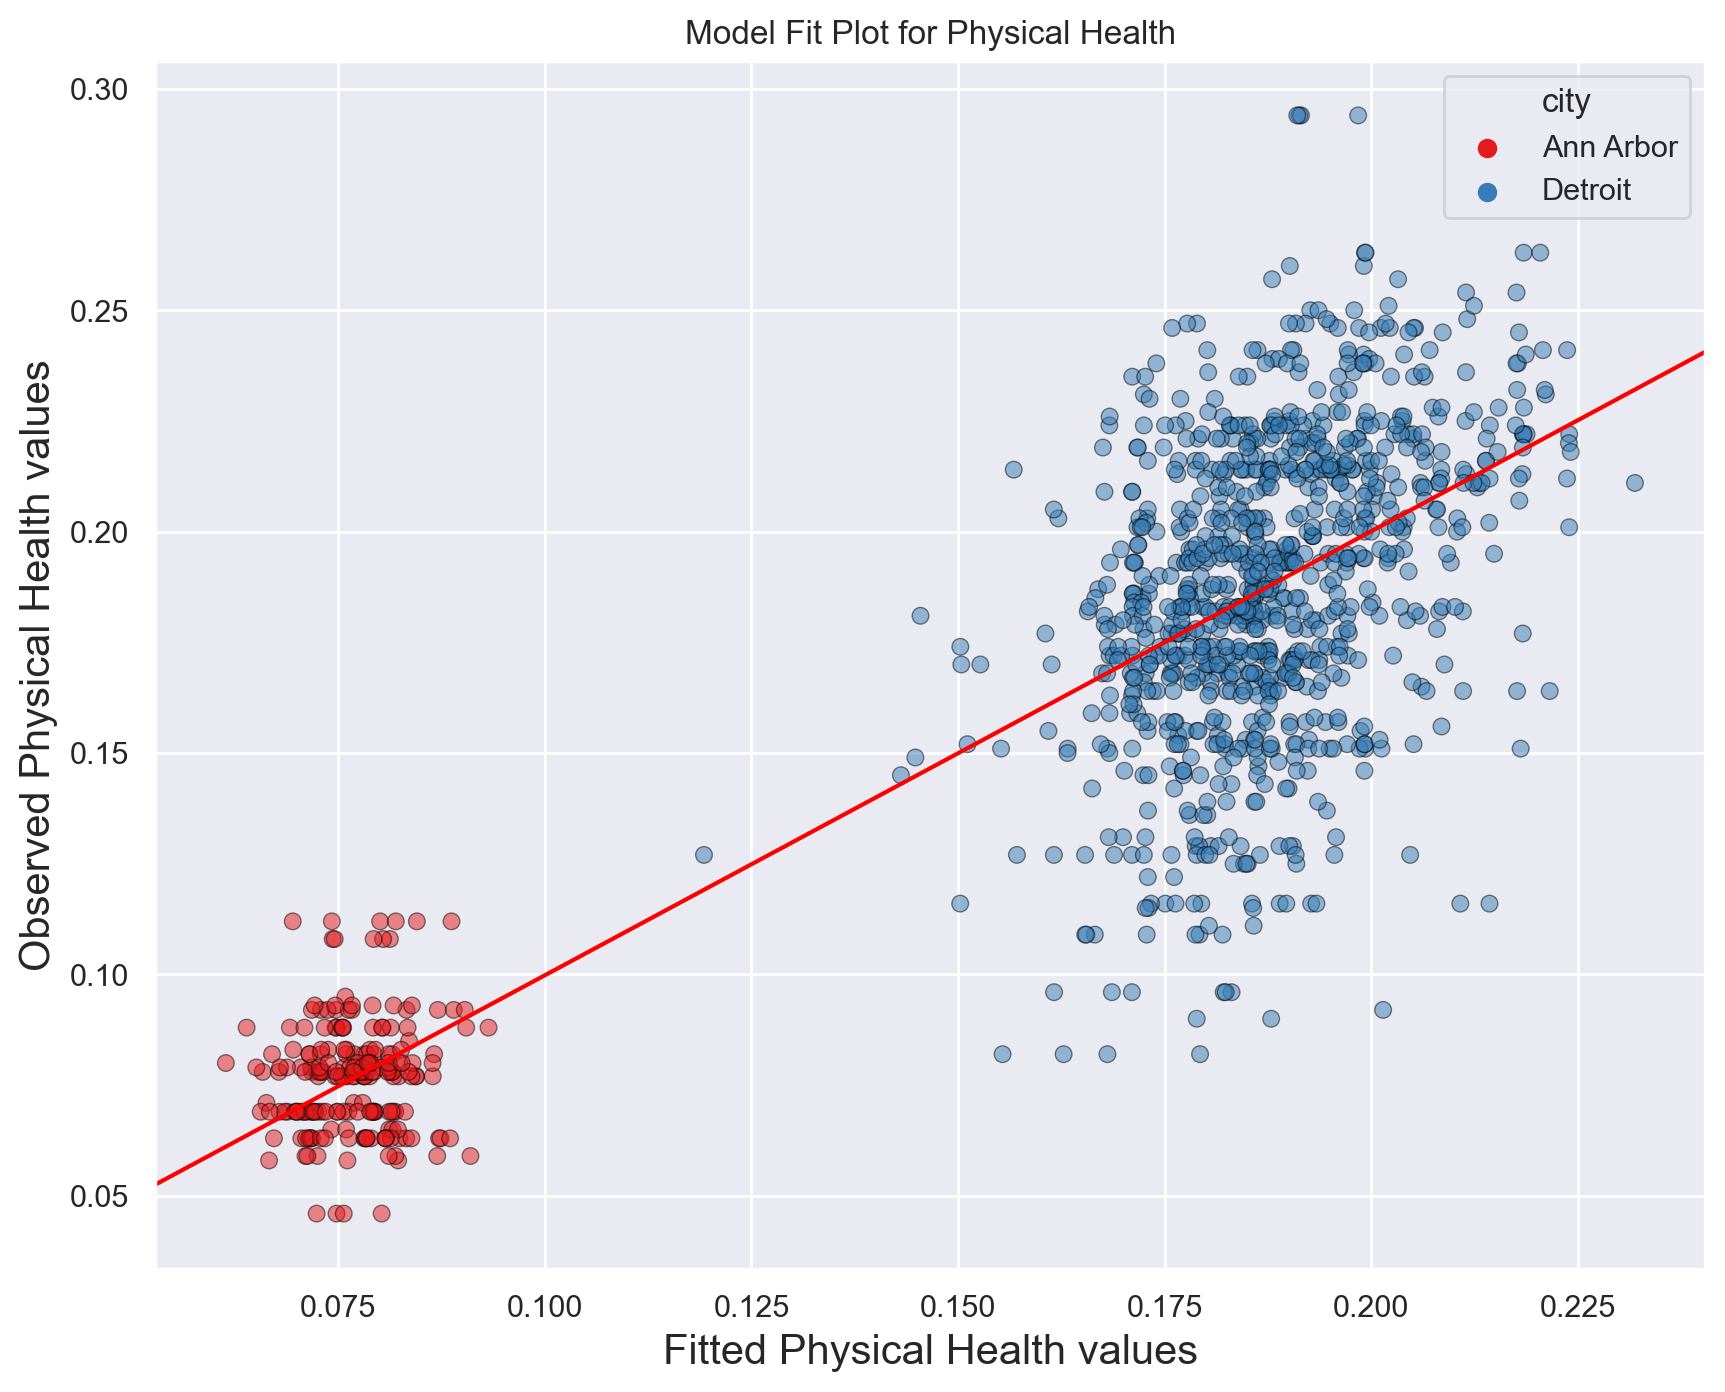

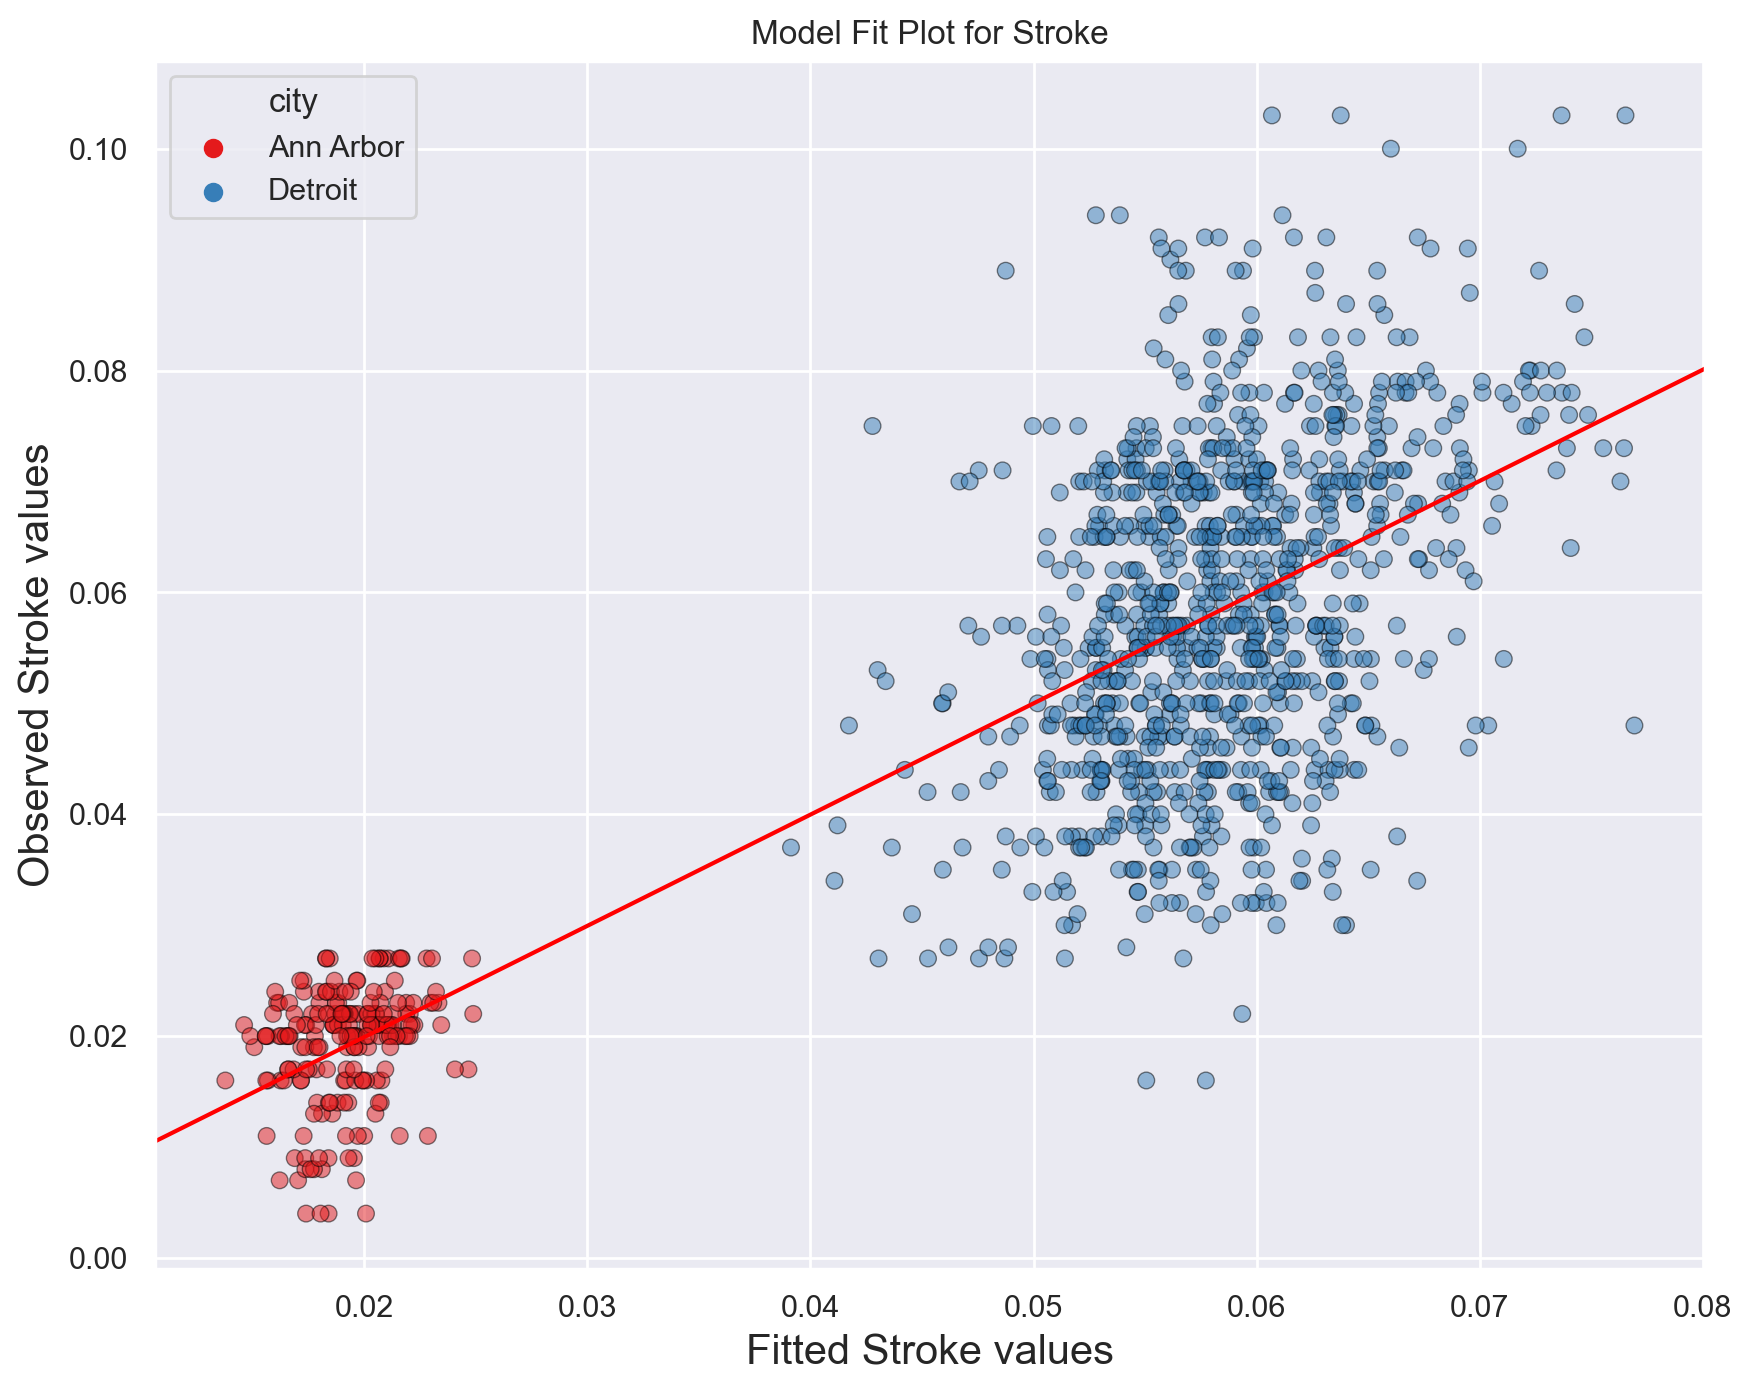

In [15]:

models = {}

for COLUMN, label in ANALYSIS_COLUMNS.items():
    print()

    # structure dependent to [0, 1] range
    Y = df[COLUMN] / 100

    """
    FEATURE SETS:
    (1) city categorical only
    (2) PCA variables (0.80 rule) and city categorical
    (3) all inclusion columns and city categorical  
    (3) all exlcuded columns and city categorical  
    """

    PCA_VARS = [x for x in df.columns if 'PCA' in x]

    # IND_VARS = ['CITY_BINARY'] # (1)
    # IND_VARS = ['CITY_BINARY'] + PCA_VARS # (2)
    IND_VARS = ['CITY_BINARY'] + INCLUSIONS  # (3)
    # IND_VARS = ['CITY_BINARY'] + EXCLUSIONS  # (4)
    X = df[IND_VARS]

    """
    GLM Binomial Link: we estimate the intercept first
    """
    X = sm.add_constant(X)
    glm_binom = sm.GLM(Y, X, family=sm.families.Binomial())
    results = glm_binom.fit()

    # print results, graph the fit, store the results
    print(results.summary())
    models[label] = results
    print()


    # plot the fit
    matplotlib.rcParams['figure.dpi'] = 200
    matplotlib.rcParams['figure.figsize'] = 4,4

    fig = utils.build_fig()

    y = Y/Y.sum()
    yhat = results.mu
    sns.scatterplot(yhat, 
                    Y, 
                    hue=df['city'], 
                    alpha=0.5, 
                    palette='Set1', 
                    edgecolor='black')

    line_fit = sm.OLS(Y, sm.add_constant(yhat)).fit()
    abline_plot(model_results=line_fit, ax=plt.gca(), c='red')
    plt.title(f'Model Fit Plot for {label}')
    plt.ylabel(f'Observed {label} values')
    plt.xlabel(f'Fitted {label} values')

    outpath = f"../figures/{label} fit.png"
    plt.savefig(outpath, bbox_inches='tight')


<AxesSubplot:xlabel='tile_longitude', ylabel='tile_latitude'>

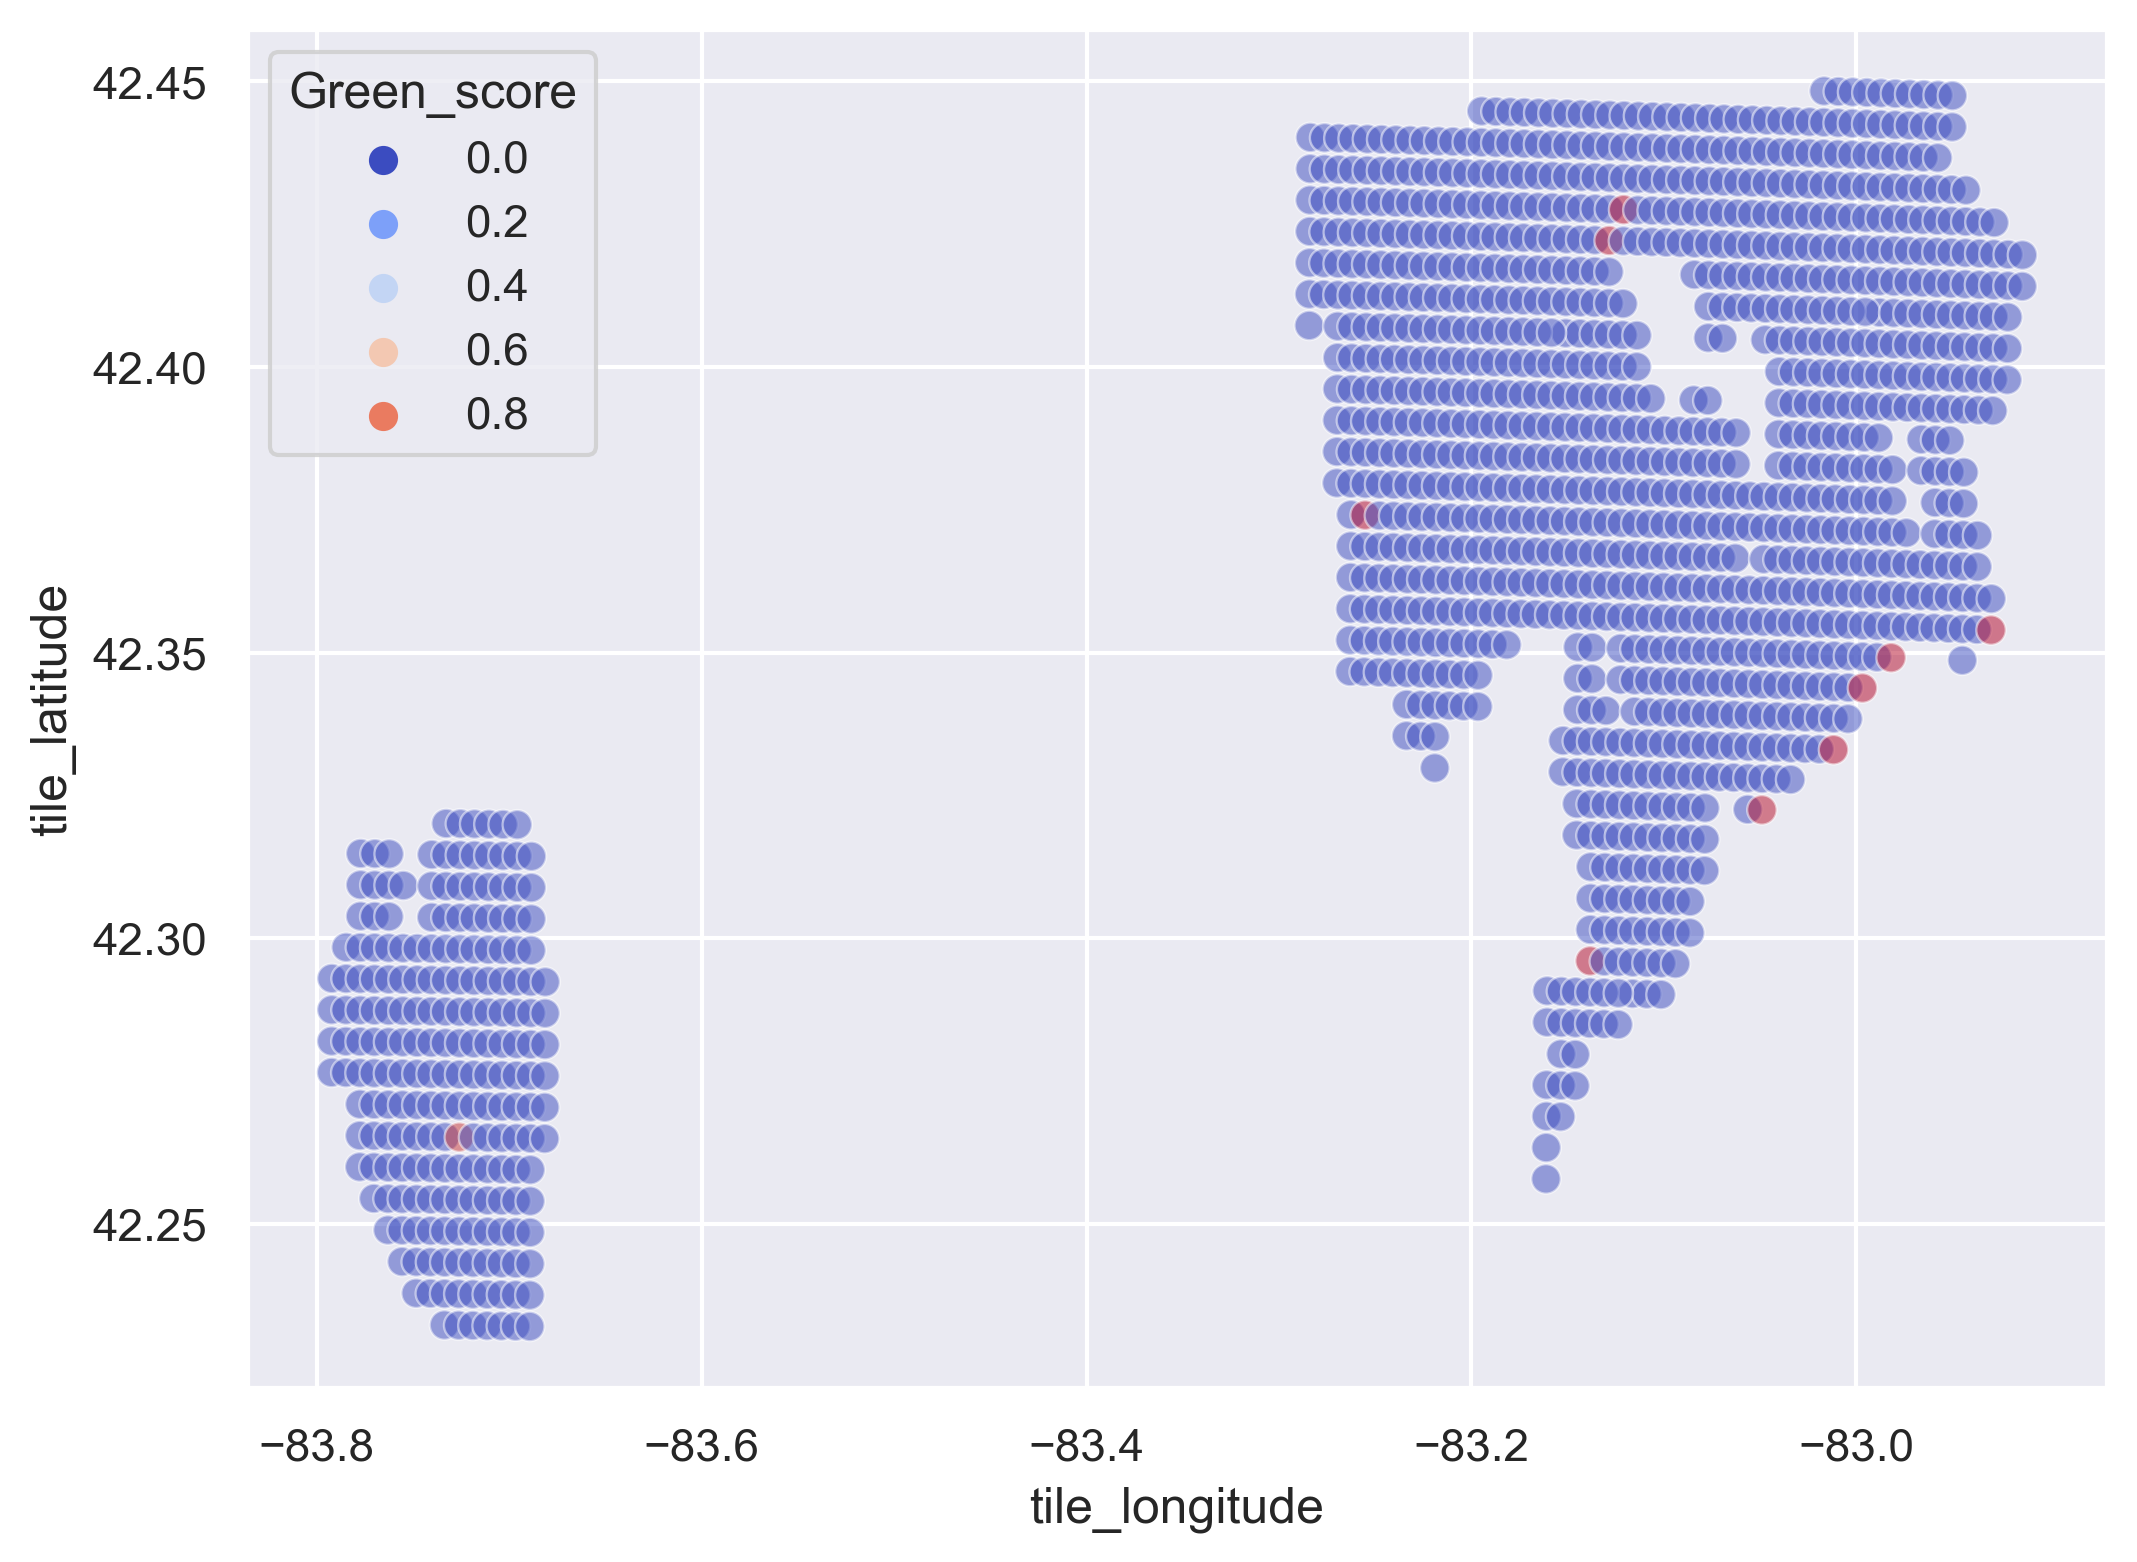

In [10]:

term = 'Green_score'

matplotlib.rcParams['figure.dpi'] = 300
matplotlib.rcParams['figure.figsize'] = 8, 6

sns.scatterplot(x=df['tile_longitude'],
                y=df['tile_latitude'], 
                hue=df[term],
                s=50,
                palette='coolwarm',
                alpha=0.5)

In [49]:
""" fit a decision tree on simplified city ranges """


for COLUMN, label in ANALYSIS_COLUMNS.items():
    # define 'hi' and 'low' based on city means
    # add city means
    CITY_MEAN_COLUMN = f'{COLUMN}_cityMean'
    df[CITY_MEAN_COLUMN] = df.groupby('city')[COLUMN].transform('mean')

    # structure dependent categories
    Y = np.where(df[COLUMN] >= df[CITY_MEAN_COLUMN], 1, 0) 

    """
    FEATURES are just scores
    """

    X = df[INCLUSIONS]

    dtclass = DecisionTreeClassifier(random_state=0).fit(X, Y)
    
    res = ml_eval.get_classification_metrics(dtclass, X, Y)
    print(res)


    break

    

 

                            0
optimal_threshold    1.000000
true negatives     470.000000
true positives     699.000000
false positives      0.000000
false negatives      3.000000
sensitivity          0.995726
specificity          1.000000
F1-score             0.997859
precision            0.997135
recall               0.997135
AUCROC               0.999986
